In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import BertTokenizer, AutoModel
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from torch.utils.data import  Dataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import classification_report
import random
import torch.optim as optim
import copy
import pickle

In [3]:
df_test= pd.read_csv('df_test.csv')
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [4]:
labels = {-1:0, 0:1, 1:2}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        df['message'] = df['message'].astype(str)
        self.labels = [labels[label] for label in df['sentiment']]
        self.encodings = tokenizer(
            list(df['message']),
            padding='max_length',
            max_length=256,
            truncation=True,
            return_tensors="pt"
        )

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [5]:
class BertCNN(nn.Module):
    def __init__(self, hidden_size=768, num_channels=256, kernel_size=7, dropout=0.2):
        super(BertCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=hidden_size, out_channels=num_channels, kernel_size=kernel_size, padding=0),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, kernel_size=5, padding=0),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, kernel_size=5, padding=0),
            nn.ReLU(),

        )
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv_layers(x)
        x = self.pool(x)
        x = x.squeeze(-1)
        x = self.dropout(x)
        return x

class Classification(nn.Module):
    def __init__(self, input_dim=256, hidden_dim=768, num_classes=3, dropout=0.2):
        super(Classification, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x

class Model(nn.Module):
    def __init__(self, dropout=0.2):
        super(Model, self).__init__()
        self.bert = AutoModel.from_pretrained('bert-base-uncased')
        hidden_size = self.bert.config.hidden_size
        self.bert_cnn = BertCNN(hidden_size=hidden_size, num_channels=128, kernel_size=7, dropout=dropout)
        self.classifier = Classification(input_dim=128, hidden_dim=128, num_classes=3, dropout=dropout)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        sequence_output = outputs[0]
        cnn_features = self.bert_cnn(sequence_output)
        logits = self.classifier(cnn_features)
        return logits

In [6]:
def evaluate(model, df_test, batch_size=32):

    test_dataset = Dataset(df_test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device).squeeze(1)
            attention_mask = batch['attention_mask'].to(device)
            labels_batch = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = outputs.argmax(dim=1)

            total_correct += (preds == labels_batch).sum().item()
            total_samples += input_ids.size(0)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels_batch.cpu().tolist())

    accuracy = total_correct / total_samples
    f1 = f1_score(all_labels, all_preds, average='weighted')

    target_names = ['0', '1', '2']
    class_report = classification_report(all_labels, all_preds, target_names=target_names, digits=4)
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])

    print(f"Test Accuracy: {accuracy:.3f}")
    print(f"Test Weighted F1 Score: {f1:.3f}")
    print("---------------------------------------------------------------------")
    print(f"Test Data:\n{class_report}")
    print(f"COnfusion Matrix:\n{conf_matrix}")
    
    df_hasil = pd.DataFrame({
        'Teks Asli': df_test['message'], 
        'Aktual': all_labels,
        'Prediksi': all_preds
    })
    
    df_hasil['Hasil'] = np.where(df_hasil['Aktual'] == df_hasil['Prediksi'], 'Benar', 'Salah')
    
    print("\n\n===== TABEL SAMPEL HASIL PREDIKSI PER DATA =====")

    return f1, class_report, conf_matrix, df_hasil

In [7]:
bestest_model = Model(dropout=0.2)
# bestest_model.load_state_dict(torch.load("best_model_bertcnn_final.pt", map_location=torch.device('cuda'), weights_only=False))
bestest_model.load_state_dict(torch.load("best_model_bertcnn_final.pt", map_location=torch.device('cuda')))
bestest_model.to(torch.device('cuda'))

/tmp/ipykernel_34049/1294648939.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bestest_model.load_state_dict(torch.load("best_model_bertcnn_final.pt", map_location=torc

Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [8]:
print(bestest_model)

Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [9]:
f1, class_report, conf_matrix, df_hasil_cnn = evaluate(bestest_model, df_test, 32)
# df_hasil_cnn.to_csv("df_hasil_bertcnn1.csv")

Test Accuracy: 0.708
Test Weighted F1 Score: 0.720
---------------------------------------------------------------------
Test Data:
              precision    recall  f1-score   support

           0     0.4744    0.7224    0.5728       771
           1     0.5307    0.6276    0.5751      1501
           2     0.8786    0.7342    0.7999      4120

    accuracy                         0.7078      6392
   macro avg     0.6279    0.6947    0.6493      6392
weighted avg     0.7482    0.7078    0.7197      6392

COnfusion Matrix:
[[ 557  126   88]
 [ 229  942  330]
 [ 388  707 3025]]


===== TABEL SAMPEL HASIL PREDIKSI PER DATA =====


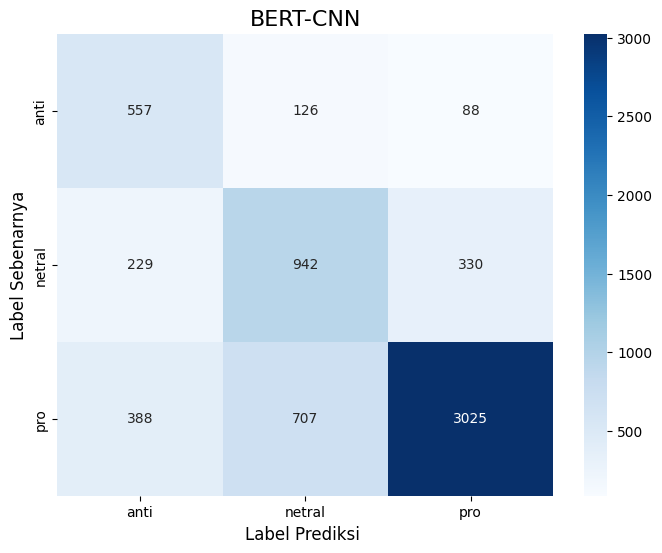

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

confusion_matrix_data = np.array([
    [557, 126, 88],
    [229, 942, 330],
    [388, 707, 3025]
])

class_names = ['anti', 'netral', 'pro']

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_data, 
            annot=True,        
            fmt='d',          
            cmap='Blues',      
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('BERT-CNN', fontsize=16)
plt.ylabel('Label Sebenarnya', fontsize=12)
plt.xlabel('Label Prediksi ', fontsize=12)
plt.show()


In [11]:
def predict_sentence(model, sentence):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs = tokenizer(
        sentence,
        padding='max_length',
        max_length=256,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(inputs['input_ids'], inputs['attention_mask'])
        pred = outputs.argmax(dim=1).item()

    label_names = ['Anti', 'Netral', 'Pro']
    print(f"Teks: {sentence}")
    print(f"Prediksi Sentimen: {label_names[pred]} (kelas: {pred})")

    return pred


In [20]:
predict_sentence(bestest_model, "it's getting hotter everyday because of climate change")

Teks: it's getting hotter everyday because of climate change
Prediksi Sentimen: Pro (kelas: 2)


2

In [21]:
predict_sentence(bestest_model, "I don't think climate change is fake")

Teks: I don't think climate change is fake
Prediksi Sentimen: Anti (kelas: 0)


0

In [22]:
predict_sentence(bestest_model, "Can i see climate change happening right now?")

Teks: Can i see climate change happening right now?
Prediksi Sentimen: Netral (kelas: 1)


1

In [ ]:


def plot_training_history(fold_history):
    """
    Plot training history for K-fold cross-validation results with average line only

    Parameters:
    fold_history: List of dictionaries containing fold results from train_model function
                 Each dict should have 'fold' and 'history' keys
                 OR
                 Dictionary with fold numbers as keys and history data as values
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Handle different input formats
    history = {}
    
    # Debug: Print input structure
    print("Debug - Input type:", type(fold_history))
    if isinstance(fold_history, dict):
        print("Debug - Keys:", list(fold_history.keys()))
        first_key = list(fold_history.keys())[0]
        print(f"Debug - First fold ({first_key}) keys:", list(fold_history[first_key].keys()))
    else:
        print("Debug - Length:", len(fold_history))
        if len(fold_history) > 0:
            print("Debug - First element keys:", list(fold_history[0].keys()))
    
    # Check if input is a list of dictionaries or a dictionary
    if isinstance(fold_history, list):
        # Original format: list of dicts with 'fold' and 'history' keys
        for fold_data in fold_history:
            fold_num = fold_data['fold']
            fold_history_data = fold_data['history']

            # Convert F1 scores from nested lists to simple lists (as in your original code)
            train_f1 = [float(np.mean(f1)) for f1 in fold_history_data['f1_score']]
            val_f1 = [float(np.mean(f1)) for f1 in fold_history_data['val_f1_score']]

            history[fold_num] = {
                'train_loss': fold_history_data['loss'],
                'val_loss': fold_history_data['val_loss'],
                'train_acc': fold_history_data['accuracy'],
                'val_acc': fold_history_data['val_accuracy'],
                'train_f1': train_f1,
                'val_f1': val_f1
            }
    else:
        # Alternative format: dictionary with fold numbers as keys
        for fold_num, fold_history_data in fold_history.items():
            print(f"Debug - Processing fold {fold_num}, available keys: {list(fold_history_data.keys())}")
            
            # Check if F1 scores need conversion
            if 'f1_score' in fold_history_data and len(fold_history_data['f1_score']) > 0 and isinstance(fold_history_data['f1_score'][0], list):
                train_f1 = [float(np.mean(f1)) for f1 in fold_history_data['f1_score']]
            else:
                train_f1 = fold_history_data.get('f1_score', [])
                
            if 'val_f1_score' in fold_history_data and len(fold_history_data['val_f1_score']) > 0 and isinstance(fold_history_data['val_f1_score'][0], list):
                val_f1 = [float(np.mean(f1)) for f1 in fold_history_data['val_f1_score']]
            else:
                val_f1 = fold_history_data.get('val_f1_score', [])

            history[fold_num] = {
                'train_loss': fold_history_data.get('loss', []),
                'val_loss': fold_history_data.get('val_loss', []),
                'train_acc': fold_history_data.get('accuracy', []),
                'val_acc': fold_history_data.get('val_accuracy', []),
                'train_f1': train_f1,
                'val_f1': val_f1
            }
            
            # Debug: Check what data we have for this fold
            for metric_key, metric_data in history[fold_num].items():
                print(f"Debug - Fold {fold_num}, {metric_key}: length={len(metric_data)}")

    # Group metrics into pairs for combined plots
    metric_pairs = [
        (['train_loss', 'val_loss'], 'Loss', 'Loss'),
        (['train_acc', 'val_acc'], 'Accuracy', 'Accuracy'),
        (['train_f1', 'val_f1'], 'F1 Score', 'F1 Score')
    ]
    
    for metrics, title, ylabel in metric_pairs:
        plt.figure(figsize=(10, 6))
        
        # Check if we have data for these metrics
        has_data = False
        
        for metric in metrics:
            # Collect all values for this metric across folds
            all_values = []
            for fold in history:
                if len(history[fold][metric]) > 0:  # Only add non-empty data
                    all_values.append(history[fold][metric])
            
            if len(all_values) == 0:
                print(f"Warning: No data found for {metric}")
                continue
                
            # Convert to numpy array and calculate mean across folds (axis=0)
            all_values = np.array(all_values)
            avg_values = np.mean(all_values, axis=0)
            
            # Plot the average line with appropriate label
            metric_type = 'Training' if 'train' in metric else 'Validation'
            plt.plot(avg_values, label=f'{metric_type} {title}', linewidth=2)
            has_data = True

        if has_data:
            plt.title(f'{title} - Average across {len(history)} folds')
            plt.xlabel('Epoch')
            plt.ylabel(ylabel)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Skipping {title} plot - no data available")
            plt.close()

    # Group metrics into pairs for combined plots
    metric_pairs = [
        (['train_loss', 'val_loss'], 'Loss', 'Loss'),
        (['train_acc', 'val_acc'], 'Accuracy', 'Accuracy'),
        (['train_f1', 'val_f1'], 'F1 Score', 'F1 Score')
    ]
    
    for metrics, title, ylabel in metric_pairs:
        plt.figure(figsize=(10, 6))
        
        for metric in metrics:
            # Collect all values for this metric across folds
            all_values = []
            for fold in history:
                all_values.append(history[fold][metric])
            
            # Convert to numpy array and calculate mean across folds (axis=0)
            all_values = np.array(all_values)
            avg_values = np.mean(all_values, axis=0)
            
            # Plot the average line with appropriate label
            metric_type = 'Training' if 'train' in metric else 'Validation'
            plt.plot(avg_values, label=f'{metric_type} {title}', linewidth=2)

        plt.title(f'{title} - Average across {len(history)} folds')
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [14]:
def plot_training_history(fold_history):
    """
    Plot training history for K-fold cross-validation results with average line only

    Parameters:
    fold_history: List of dictionaries containing fold results from train_model function
                 Each dict should have 'fold' and 'history' keys
                 OR
                 Dictionary with fold numbers as keys and history data as values
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Handle different input formats
    history = {}
    
    # Check if input is a list of dictionaries or a dictionary
    if isinstance(fold_history, list):
        # Original format: list of dicts with 'fold' and 'history' keys
        for fold_data in fold_history:
            fold_num = fold_data['fold']
            fold_history_data = fold_data['history']

            # Convert F1 scores from nested lists to simple lists (as in your original code)
            train_f1 = [float(np.mean(f1)) for f1 in fold_history_data['f1_score']]
            val_f1 = [float(np.mean(f1)) for f1 in fold_history_data['val_f1_score']]

            history[fold_num] = {
                'train_loss': fold_history_data['loss'],
                'val_loss': fold_history_data['val_loss'],
                'train_acc': fold_history_data['accuracy'],
                'val_acc': fold_history_data['val_accuracy'],
                'train_f1': train_f1,
                'val_f1': val_f1
            }
    else:
        # Alternative format: dictionary with fold numbers as keys
        for fold_num, fold_history_data in fold_history.items():
            # Check if F1 scores need conversion
            if 'f1_score' in fold_history_data and isinstance(fold_history_data['f1_score'][0], list):
                train_f1 = [float(np.mean(f1)) for f1 in fold_history_data['f1_score']]
                val_f1 = [float(np.mean(f1)) for f1 in fold_history_data['val_f1_score']]
            else:
                train_f1 = fold_history_data.get('f1_score', [])
                val_f1 = fold_history_data.get('val_f1_score', [])

            history[fold_num] = {
                'train_loss': fold_history_data.get('loss', []),
                'val_loss': fold_history_data.get('val_loss', []),
                'train_acc': fold_history_data.get('accuracy', []),
                'val_acc': fold_history_data.get('val_accuracy', []),
                'train_f1': train_f1,
                'val_f1': val_f1
            }

    # Group metrics into pairs for combined plots
    metric_pairs = [
        (['train_loss', 'val_loss'], 'Loss', 'Loss'),
        (['train_acc', 'val_acc'], 'Accuracy', 'Accuracy'),
        (['train_f1', 'val_f1'], 'F1 Score', 'F1 Score')
    ]
    
    for metrics, title, ylabel in metric_pairs:
        plt.figure(figsize=(10, 6))
        
        for metric in metrics:
            # Collect all values for this metric across folds
            all_values = []
            for fold in history:
                all_values.append(history[fold][metric])
            
            # Convert to numpy array and calculate mean across folds (axis=0)
            all_values = np.array(all_values)
            avg_values = np.mean(all_values, axis=0)
            
            # Plot the average line with appropriate label
            metric_type = 'Training' if 'train' in metric else 'Validation'
            plt.plot(avg_values, label=f'{metric_type} {title}', linewidth=2)

        plt.title(f'{title} - Average across {len(history)} folds')
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [12]:
with open("history_train_bertcnn_final.pkl", "rb") as f:
    history_train_bertcnn = pickle.load(f)

In [ ]:
plot_training_history(history_train_bertcnn)